# SSY340 Project - Trajectory Estimation

### Fill in group number and member names:

In [1]:
NAME1 = "Bingcheng Chen" 
NAME2 = "Arvin Rokni"
GROUP = "Project groups 64"

## 1. Loading the data

In [2]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import os
import dataloader
import model_Transformer
import utils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## 2. Pre-processing

In [3]:
# defining model save location
save_location = "./models"
# defining dataset locations
dataset_folder = "./datasets"
dataset_name = "raw"
# setting validation size. if val_size = 0, split percentage is 80-20
val_size = 0
# length of sequence given to encoder
gt = 8
# length of sequence given to decoder
horizon = 12


train_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
    gt, horizon, delim="\t", train=True)
val_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
    gt, horizon, delim="\t", train=False)
# test_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
#     gt, horizon, delim="\t", train=False, eval=True)

In [4]:
val_dataset[10]

{'src': tensor([[3.7341e+00, 8.0111e+00, 0.0000e+00, 0.0000e+00],
         [3.7469e+00, 8.1700e+00, 1.2838e-02, 1.5895e-01],
         [3.7597e+00, 8.3292e+00, 1.2838e-02, 1.5919e-01],
         [3.7673e+00, 8.4636e+00, 7.5767e-03, 1.3437e-01],
         [3.7673e+00, 8.5607e+00, 0.0000e+00, 9.7135e-02],
         [3.7673e+00, 8.6581e+00, 0.0000e+00, 9.7373e-02],
         [3.7673e+00, 8.7552e+00, 0.0000e+00, 9.7135e-02],
         [3.7673e+00, 8.8526e+00, 0.0000e+00, 9.7373e-02]]),
 'trg': tensor([[ 3.7673,  8.9497,  0.0000,  0.0971],
         [ 3.7549,  8.9602, -0.0124,  0.0105],
         [ 3.7423,  8.9710, -0.0126,  0.0107],
         [ 3.7299,  8.9815, -0.0124,  0.0105],
         [ 3.7174,  8.9922, -0.0124,  0.0107],
         [ 3.7050,  9.0027, -0.0124,  0.0105],
         [ 3.6924,  9.0135, -0.0126,  0.0107],
         [ 3.6800,  9.0240, -0.0124,  0.0105],
         [ 3.6676,  9.0347, -0.0124,  0.0107],
         [ 3.6551,  9.0452, -0.0124,  0.0105],
         [ 3.6425,  9.0557, -0.0126,  0.01

In [5]:
val_dataset[10]['src'].shape

torch.Size([8, 4])

## 3. Data loaders

In [6]:
# defining batch size
batch_size = 64

# creating torch dataloaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=0)

In [7]:
# calculating the mean and standard deviation of velocities of the entire dataset
mean = torch.cat((train_dataset[:]['src'][:, 1:, 2:4],
                    train_dataset[:]['trg'][:, :, 2:4]), 1).mean((0, 1))
std = torch.cat((train_dataset[:]['src'][:, 1:, 2:4],
                train_dataset[:]['trg'][:, :, 2:4]), 1).std((0, 1))
means = []
stds = []
for i in np.unique(train_dataset[:]['dataset']):
    ind = train_dataset[:]['dataset'] == i
    means.append(torch.cat(
        (train_dataset[:]['src'][ind, 1:, 2:4], train_dataset[:]['trg'][ind, :, 2:4]), 1).mean((0, 1)))
    stds.append(
        torch.cat((train_dataset[:]['src'][ind, 1:, 2:4], train_dataset[:]['trg'][ind, :, 2:4]), 1).std((0, 1)))
mean = torch.stack(means).mean(0)
std = torch.stack(stds).mean(0)

## 4. Training

#### 4.1 create a model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tf_model = model_Transformer.Transformer(encoder_input_size=2, decoder_input_size=3,
                                embedding_size=512, num_heads=8, num_layers=6, feedforward_size=2048).to(device)

In [9]:
tf_model

Transformer(
  (encoder_embedding): Embeddings(
    (linear_embd): Linear(in_features=2, out_features=512, bias=True)
  )
  (decoder_embedding): Embeddings(
    (linear_embd): Linear(in_features=3, out_features=512, bias=True)
  )
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_af

#### 4.2 The training loop

In [12]:
iterations = 70

# creating optimizer
optimizer = torch.optim.SGD(tf_model.parameters(
), lr=1e-4, momentum=0.9, weight_decay=1e-3, nesterov=True)
# optimizer = torch.optim.Adam(tf_model.parameters(), lr=1e-4)

train_loss, learning_rates = utils.learning_rate_finder(
    tf_model, optimizer, train_loader, iterations, device, mean, std)
eta_star = learning_rates[np.argmin(np.array(train_loss))]
eta_max = eta_star/10
print("Value of eta max is: {:.4f}".format(eta_max))

# plotting results
# plt.figure()
# plt.plot(learning_rates, train_loss)
# plt.xlabel("Learning rates")
# plt.ylabel("Training loss")
# plt.xscale('log')
# plt.title("Learning Rate Finder Algorithm")
# plt.show()

# number of epochs
epochs = 100

# metric variables
training_loss = []
validation_loss = []
val_mad = []
val_fad = []

# finding the total number of weight updates for the network
T = epochs * len(train_loader)
# initializing variable to track the number of weight updates
weight_update = 0
# initializing variable to store the changing learning rate
learning_rate = []

for epoch in tqdm(range(epochs)):
    # TRAINING MODE
    tf_model.train()

    # training batch variables
    train_batch_loss = 0

    for idx, data in enumerate(train_loader):
        # changing the learning rate based on cosine scheduler
        lr = utils.cosine_scheduler(weight_update, eta_max, T)
        for param in optimizer.param_groups:
            learning_rate.append(lr)
            param['lr'] = lr
        weight_update += 1

        # getting encoder input data
        # (64, 7, 512)
        enc_input = (data['src'][:, 1:, 2:4].to(
            device)-mean.to(device))/std.to(device)

        # getting decoder input data
        target = (data['trg'][:, :-1, 2:4].to(device) -
                    mean.to(device))/std.to(device)
        target_append = torch.zeros(
            (target.shape[0], target.shape[1], 1)).to(device)
        target = torch.cat((target, target_append), -1)
        start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(
            0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
        (64, 12, 512)
        dec_input = torch.cat((start_of_seq, target), 1)

        # getting masks for decoder
        dec_source_mask = torch.ones(
            (enc_input.shape[0], 1, enc_input.shape[1])).to(device)
        dec_target_mask = utils.subsequent_mask(
            dec_input.shape[1]).repeat(dec_input.shape[0], 1, 1).to(device)

        # forward pass
        optimizer.zero_grad()
        # predictions = tf_model.forward(enc_input, dec_input, dec_source_mask, dec_target_mask)
        predictions = tf_model.forward(enc_input, dec_input)

        # calculating loss using pairwise distance of all predictions
        loss = F.pairwise_distance(predictions[:, :, 0:2].contiguous().view(-1, 2),
                                    ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).
                                    contiguous().view(-1, 2).to(device)).mean() + \
            torch.mean(torch.abs(predictions[:, :, 2]))
        train_batch_loss += loss.item()

        # updating weights
        loss.backward()
        optimizer.step()

    training_loss.append(train_batch_loss/len(train_loader))
    print("Epoch {}/{}....Training loss = {:.4f}".format(epoch +
            1, epochs, training_loss[-1]))

    # validation loop
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            # EVALUATION MODE
            tf_model.eval()

            # validation variables
            batch_val_loss = 0
            gt = []
            pr = []

            for id_b, data in enumerate(val_loader):
                # storing groung truth
                gt.append(data['trg'][:, :, 0:2])

                # input to encoder input
                val_input = (data['src'][:, 1:, 2:4].to(
                    device)-mean.to(device))/std.to(device)

                # input to decoder
                start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(
                    1).repeat(val_input.shape[0], 1, 1).to(device)
                dec_inp = start_of_seq
                # decoder masks
                dec_source_mask = torch.ones(
                    (val_input.shape[0], 1, val_input.shape[1])).to(device)
                dec_target_mask = utils.subsequent_mask(
                    dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

                # prediction till horizon lenght
                for i in range(horizon):
                    # getting model prediction
                    # model_output = tf_model.forward(val_input, dec_inp, dec_source_mask, dec_target_mask)
                    model_output = tf_model.forward(val_input, dec_inp)

                    # appending the predicition to decoder input for next cycle
                    dec_inp = torch.cat(
                        (dec_inp, model_output[:, -1:, :]), 1)

                # calculating loss using pairwise distance of all predictions
                val_loss = F.pairwise_distance(dec_inp[:, 1:, 0:2].contiguous().view(-1, 2),
                                                ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).
                                                contiguous().view(-1, 2).to(device)).mean() + \
                    torch.mean(torch.abs(dec_inp[:, 1:, 2]))
                batch_val_loss += val_loss.item()

                # calculating the position for each time step of prediction based on velocity
                preds_tr_b = (dec_inp[:, 1:, 0:2]*std.to(device) + mean.to(device)).cpu().numpy().cumsum(1) + \
                    data['src'][:, -1:, 0:2].cpu().numpy()

                pr.append(preds_tr_b)
            validation_loss.append(batch_val_loss/len(val_loader))

            # calculating mad and fad evaluation metrics
            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            mad, fad, _ = dataloader.distance_metrics(gt, pr)
            val_mad.append(mad)
            val_fad.append(fad)

            print("Epoch {}/{}....Validation mad = {:.4f}, Validation fad = {:.4f}".format(
                epoch+1, epochs, mad, fad))

    if epoch == epochs - 1:
        # Saving model, loss and error log files
        torch.save({
            'model_state_dict': tf_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_loss': training_loss,
            'validation_loss': validation_loss,
            'val_mad': val_mad,
            'val_fad': val_fad,
            'learning_rate': learning_rate
        }, os.path.join(save_location, 'epoch{}.pth'.format(epoch+1)))


Value of eta max is: 0.0003


  1%|██                                                                                                                                                                                                          | 1/100 [00:33<55:39, 33.74s/it]

Epoch 1/100....Training loss = 1.0395


  2%|████                                                                                                                                                                                                        | 2/100 [01:06<54:30, 33.38s/it]

Epoch 2/100....Training loss = 1.0123


  3%|██████                                                                                                                                                                                                      | 3/100 [01:40<53:52, 33.33s/it]

Epoch 3/100....Training loss = 1.0022


  4%|████████▏                                                                                                                                                                                                   | 4/100 [02:13<53:17, 33.31s/it]

Epoch 4/100....Training loss = 1.0002
Epoch 5/100....Training loss = 1.0000


  5%|██████████                                                                                                                                                                                                | 5/100 [03:01<1:01:20, 38.74s/it]

Epoch 5/100....Validation mad = 1.5433, Validation fad = 2.8128


  6%|████████████▏                                                                                                                                                                                               | 6/100 [03:35<57:47, 36.89s/it]

Epoch 6/100....Training loss = 0.9994


  7%|██████████████▎                                                                                                                                                                                             | 7/100 [04:08<55:18, 35.69s/it]

Epoch 7/100....Training loss = 0.9993


  8%|████████████████▎                                                                                                                                                                                           | 8/100 [04:41<53:32, 34.92s/it]

Epoch 8/100....Training loss = 0.9995


  9%|██████████████████▎                                                                                                                                                                                         | 9/100 [05:14<52:08, 34.38s/it]

Epoch 9/100....Training loss = 0.9987
Epoch 10/100....Training loss = 0.9985


 10%|████████████████████▎                                                                                                                                                                                      | 10/100 [06:03<58:02, 38.70s/it]

Epoch 10/100....Validation mad = 1.5423, Validation fad = 2.8109


 11%|██████████████████████▎                                                                                                                                                                                    | 11/100 [06:36<54:54, 37.02s/it]

Epoch 11/100....Training loss = 0.9988


 12%|████████████████████████▎                                                                                                                                                                                  | 12/100 [07:09<52:33, 35.84s/it]

Epoch 12/100....Training loss = 0.9988


 13%|██████████████████████████▍                                                                                                                                                                                | 13/100 [07:42<50:48, 35.04s/it]

Epoch 13/100....Training loss = 0.9984


 14%|████████████████████████████▍                                                                                                                                                                              | 14/100 [08:15<49:24, 34.47s/it]

Epoch 14/100....Training loss = 0.9988
Epoch 15/100....Training loss = 0.9986


 15%|██████████████████████████████▍                                                                                                                                                                            | 15/100 [09:04<54:45, 38.66s/it]

Epoch 15/100....Validation mad = 1.5422, Validation fad = 2.8109


 16%|████████████████████████████████▍                                                                                                                                                                          | 16/100 [09:37<51:49, 37.01s/it]

Epoch 16/100....Training loss = 0.9985


 17%|██████████████████████████████████▌                                                                                                                                                                        | 17/100 [10:10<49:35, 35.85s/it]

Epoch 17/100....Training loss = 0.9983


 18%|████████████████████████████████████▌                                                                                                                                                                      | 18/100 [10:43<47:55, 35.06s/it]

Epoch 18/100....Training loss = 0.9983


 19%|██████████████████████████████████████▌                                                                                                                                                                    | 19/100 [11:16<46:33, 34.49s/it]

Epoch 19/100....Training loss = 0.9982
Epoch 20/100....Training loss = 0.9982


 20%|████████████████████████████████████████▌                                                                                                                                                                  | 20/100 [12:05<51:30, 38.64s/it]

Epoch 20/100....Validation mad = 1.5423, Validation fad = 2.8109


 21%|██████████████████████████████████████████▋                                                                                                                                                                | 21/100 [12:38<48:43, 37.01s/it]

Epoch 21/100....Training loss = 0.9979


 22%|████████████████████████████████████████████▋                                                                                                                                                              | 22/100 [13:11<46:37, 35.87s/it]

Epoch 22/100....Training loss = 0.9982


 23%|██████████████████████████████████████████████▋                                                                                                                                                            | 23/100 [13:44<45:02, 35.10s/it]

Epoch 23/100....Training loss = 0.9981


 24%|████████████████████████████████████████████████▋                                                                                                                                                          | 24/100 [14:18<43:43, 34.53s/it]

Epoch 24/100....Training loss = 0.9977
Epoch 25/100....Training loss = 0.9980


 25%|██████████████████████████████████████████████████▊                                                                                                                                                        | 25/100 [15:06<48:17, 38.63s/it]

Epoch 25/100....Validation mad = 1.5422, Validation fad = 2.8107


 26%|████████████████████████████████████████████████████▊                                                                                                                                                      | 26/100 [15:39<45:37, 36.99s/it]

Epoch 26/100....Training loss = 0.9978


 27%|██████████████████████████████████████████████████████▊                                                                                                                                                    | 27/100 [16:12<43:34, 35.82s/it]

Epoch 27/100....Training loss = 0.9978


 28%|████████████████████████████████████████████████████████▊                                                                                                                                                  | 28/100 [16:45<42:01, 35.02s/it]

Epoch 28/100....Training loss = 0.9978


 29%|██████████████████████████████████████████████████████████▊                                                                                                                                                | 29/100 [17:18<40:44, 34.43s/it]

Epoch 29/100....Training loss = 0.9977
Epoch 30/100....Training loss = 0.9975


 30%|████████████████████████████████████████████████████████████▉                                                                                                                                              | 30/100 [18:06<44:56, 38.52s/it]

Epoch 30/100....Validation mad = 1.5423, Validation fad = 2.8109


 31%|██████████████████████████████████████████████████████████████▉                                                                                                                                            | 31/100 [18:40<42:26, 36.91s/it]

Epoch 31/100....Training loss = 0.9978


 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                          | 32/100 [19:13<40:31, 35.76s/it]

Epoch 32/100....Training loss = 0.9976


 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                        | 33/100 [19:46<39:03, 34.98s/it]

Epoch 33/100....Training loss = 0.9977


 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                      | 34/100 [20:19<37:50, 34.40s/it]

Epoch 34/100....Training loss = 0.9973
Epoch 35/100....Training loss = 0.9974


 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                    | 35/100 [21:07<41:43, 38.51s/it]

Epoch 35/100....Validation mad = 1.5420, Validation fad = 2.8103


 36%|█████████████████████████████████████████████████████████████████████████                                                                                                                                  | 36/100 [21:40<39:21, 36.90s/it]

Epoch 36/100....Training loss = 0.9976


 37%|███████████████████████████████████████████████████████████████████████████                                                                                                                                | 37/100 [22:13<37:32, 35.75s/it]

Epoch 37/100....Training loss = 0.9978


 38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 38/100 [22:46<36:08, 34.97s/it]

Epoch 38/100....Training loss = 0.9973


 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 39/100 [23:19<34:58, 34.40s/it]

Epoch 39/100....Training loss = 0.9974
Epoch 40/100....Training loss = 0.9974


 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 40/100 [24:07<38:30, 38.52s/it]

Epoch 40/100....Validation mad = 1.5422, Validation fad = 2.8107


 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 41/100 [24:41<36:17, 36.90s/it]

Epoch 41/100....Training loss = 0.9978


 42%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 42/100 [25:14<34:33, 35.76s/it]

Epoch 42/100....Training loss = 0.9973


 43%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 43/100 [25:47<33:13, 34.97s/it]

Epoch 43/100....Training loss = 0.9976


 44%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 44/100 [26:20<32:06, 34.40s/it]

Epoch 44/100....Training loss = 0.9973
Epoch 45/100....Training loss = 0.9975


 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 45/100 [27:08<35:18, 38.52s/it]

Epoch 45/100....Validation mad = 1.5421, Validation fad = 2.8106


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 46/100 [27:41<33:13, 36.92s/it]

Epoch 46/100....Training loss = 0.9975


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 47/100 [28:14<31:35, 35.77s/it]

Epoch 47/100....Training loss = 0.9975


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 48/100 [28:47<30:19, 35.00s/it]

Epoch 48/100....Training loss = 0.9973


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 49/100 [29:21<29:16, 34.45s/it]

Epoch 49/100....Training loss = 0.9971
Epoch 50/100....Training loss = 0.9970


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 50/100 [30:09<32:07, 38.56s/it]

Epoch 50/100....Validation mad = 1.5423, Validation fad = 2.8110


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 51/100 [30:42<30:09, 36.94s/it]

Epoch 51/100....Training loss = 0.9973


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 52/100 [31:15<28:37, 35.77s/it]

Epoch 52/100....Training loss = 0.9974


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 53/100 [31:48<27:24, 34.99s/it]

Epoch 53/100....Training loss = 0.9973


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 54/100 [32:21<26:22, 34.41s/it]

Epoch 54/100....Training loss = 0.9971
Epoch 55/100....Training loss = 0.9970


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 55/100 [33:09<28:53, 38.52s/it]

Epoch 55/100....Validation mad = 1.5421, Validation fad = 2.8106


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 56/100 [33:42<27:03, 36.90s/it]

Epoch 56/100....Training loss = 0.9973


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 57/100 [34:16<25:37, 35.76s/it]

Epoch 57/100....Training loss = 0.9969


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 58/100 [34:49<24:29, 34.98s/it]

Epoch 58/100....Training loss = 0.9972


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 59/100 [35:22<23:31, 34.43s/it]

Epoch 59/100....Training loss = 0.9971
Epoch 60/100....Training loss = 0.9972


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 60/100 [36:10<25:41, 38.53s/it]

Epoch 60/100....Validation mad = 1.5421, Validation fad = 2.8105


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 61/100 [36:43<24:00, 36.93s/it]

Epoch 61/100....Training loss = 0.9973


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 62/100 [37:16<22:39, 35.78s/it]

Epoch 62/100....Training loss = 0.9971


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 63/100 [37:49<21:34, 34.99s/it]

Epoch 63/100....Training loss = 0.9974


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 64/100 [38:22<20:39, 34.42s/it]

Epoch 64/100....Training loss = 0.9969
Epoch 65/100....Training loss = 0.9971


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 65/100 [39:11<22:27, 38.51s/it]

Epoch 65/100....Validation mad = 1.5422, Validation fad = 2.8108


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 66/100 [39:44<20:54, 36.89s/it]

Epoch 66/100....Training loss = 0.9969


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 67/100 [40:17<19:39, 35.75s/it]

Epoch 67/100....Training loss = 0.9971


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 68/100 [40:50<18:39, 34.98s/it]

Epoch 68/100....Training loss = 0.9971


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 69/100 [41:23<17:47, 34.43s/it]

Epoch 69/100....Training loss = 0.9967
Epoch 70/100....Training loss = 0.9972


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 70/100 [42:11<19:16, 38.56s/it]

Epoch 70/100....Validation mad = 1.5423, Validation fad = 2.8110


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 71/100 [42:44<17:51, 36.95s/it]

Epoch 71/100....Training loss = 0.9968


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 72/100 [43:18<16:42, 35.80s/it]

Epoch 72/100....Training loss = 0.9969


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 73/100 [43:51<15:45, 35.00s/it]

Epoch 73/100....Training loss = 0.9969


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 74/100 [44:24<14:55, 34.44s/it]

Epoch 74/100....Training loss = 0.9971
Epoch 75/100....Training loss = 0.9974


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 75/100 [45:12<16:02, 38.51s/it]

Epoch 75/100....Validation mad = 1.5424, Validation fad = 2.8111


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 76/100 [45:45<14:45, 36.89s/it]

Epoch 76/100....Training loss = 0.9970


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 77/100 [46:18<13:42, 35.74s/it]

Epoch 77/100....Training loss = 0.9970


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 78/100 [46:51<12:48, 34.95s/it]

Epoch 78/100....Training loss = 0.9971


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 79/100 [47:24<12:02, 34.39s/it]

Epoch 79/100....Training loss = 0.9967
Epoch 80/100....Training loss = 0.9968


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 80/100 [48:12<12:49, 38.47s/it]

Epoch 80/100....Validation mad = 1.5422, Validation fad = 2.8108


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 81/100 [48:45<11:40, 36.86s/it]

Epoch 81/100....Training loss = 0.9968


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 82/100 [49:18<10:43, 35.73s/it]

Epoch 82/100....Training loss = 0.9968


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 83/100 [49:52<09:54, 34.96s/it]

Epoch 83/100....Training loss = 0.9969


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 84/100 [50:25<09:10, 34.41s/it]

Epoch 84/100....Training loss = 0.9972
Epoch 85/100....Training loss = 0.9972


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 85/100 [51:13<09:37, 38.52s/it]

Epoch 85/100....Validation mad = 1.5423, Validation fad = 2.8111


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 86/100 [51:46<08:36, 36.91s/it]

Epoch 86/100....Training loss = 0.9970


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 87/100 [52:19<07:44, 35.76s/it]

Epoch 87/100....Training loss = 0.9970


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 88/100 [52:52<06:59, 34.97s/it]

Epoch 88/100....Training loss = 0.9971


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 89/100 [53:25<06:18, 34.41s/it]

Epoch 89/100....Training loss = 0.9968
Epoch 90/100....Training loss = 0.9969


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 90/100 [54:13<06:24, 38.48s/it]

Epoch 90/100....Validation mad = 1.5423, Validation fad = 2.8110


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 91/100 [54:46<05:31, 36.88s/it]

Epoch 91/100....Training loss = 0.9969


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 92/100 [55:19<04:46, 35.75s/it]

Epoch 92/100....Training loss = 0.9972


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 93/100 [55:53<04:04, 34.99s/it]

Epoch 93/100....Training loss = 0.9971


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 94/100 [56:26<03:26, 34.45s/it]

Epoch 94/100....Training loss = 0.9972
Epoch 95/100....Training loss = 0.9971


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 95/100 [57:14<03:12, 38.53s/it]

Epoch 95/100....Validation mad = 1.5423, Validation fad = 2.8110


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 96/100 [57:47<02:27, 36.91s/it]

Epoch 96/100....Training loss = 0.9966


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 97/100 [58:20<01:47, 35.76s/it]

Epoch 97/100....Training loss = 0.9970


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 98/100 [58:53<01:09, 34.97s/it]

Epoch 98/100....Training loss = 0.9971


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99/100 [59:26<00:34, 34.42s/it]

Epoch 99/100....Training loss = 0.9972
Epoch 100/100....Training loss = 0.9970
Epoch 100/100....Validation mad = 1.5423, Validation fad = 2.8110


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:00:15<00:00, 36.16s/it]


## 5. Visualisation

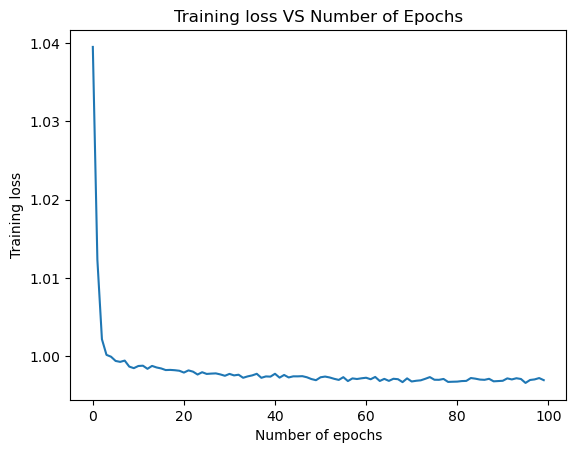

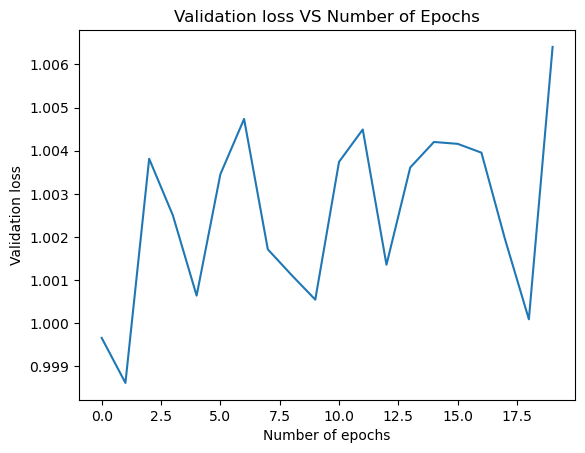

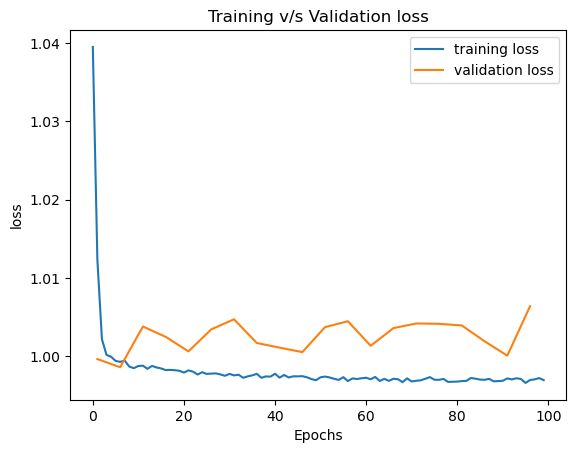

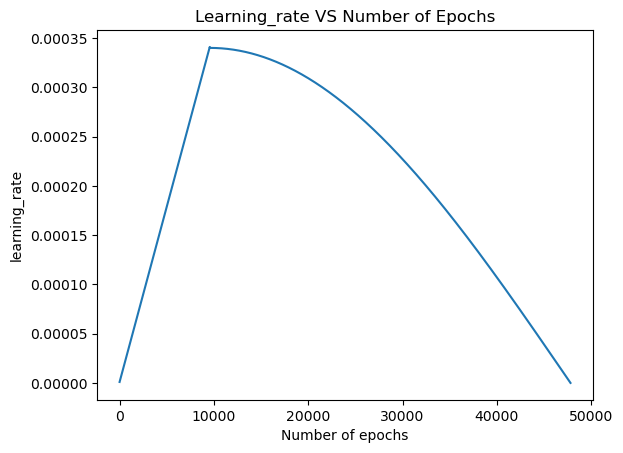

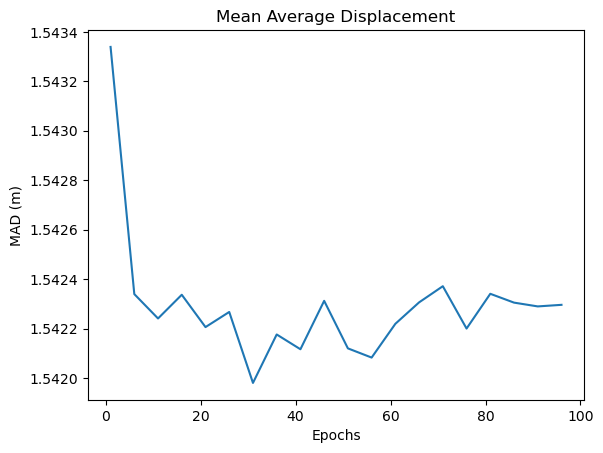

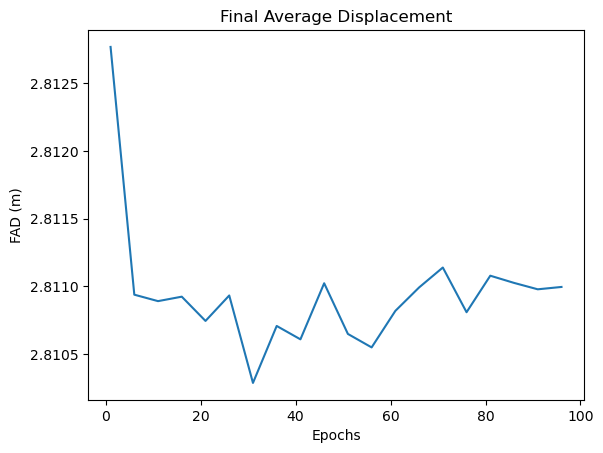

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_file = torch.load(os.path.join(
    save_location, 'epoch100.pth'), map_location=torch.device(device))

# creating model and loading weights
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout = 0.1

# model_loaded = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size,
#                              num_heads, ff_hidden_size, n, dropout=0.1)

model_loaded = model_Transformer.Transformer(encoder_input_size=2, decoder_input_size=3,
                                embedding_size=512, num_heads=8, num_layers=6, feedforward_size=2048)


model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(loaded_file['model_state_dict'])

# loading training metric variables
training_loss = loaded_file['training_loss']
validation_loss = loaded_file['validation_loss']
val_mad = loaded_file['val_mad']
val_fad = loaded_file['val_fad']
learning_rate = loaded_file['learning_rate']

# plotting training loss
plt.figure()
plt.plot(training_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Training loss VS Number of Epochs")

# plotting validation loss
plt.figure()
plt.plot(validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss VS Number of Epochs")

# plotting training and validation loss together
plt.figure()
plt.plot(loaded_file['training_loss'], label="training loss")
plt.plot(np.arange(1, 100, 5),
            loaded_file['validation_loss'], label="validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Training v/s Validation loss")
plt.savefig("loss.png")

# plotting learning rate for model
plt.figure()
plt.plot(learning_rate)
plt.xlabel("Number of epochs")
plt.ylabel("learning_rate")
plt.title("Learning_rate VS Number of Epochs")

# plotting MAD
plt.figure()
plt.plot(np.arange(1, 100, 5),
            loaded_file['val_mad'], label="validation MAD")
plt.xlabel("Epochs")
plt.ylabel("MAD (m)")
plt.title("Mean Average Displacement")
plt.savefig("mad.png")

# plotting FAD
plt.figure()
plt.plot(np.arange(1, 100, 5),
            loaded_file['val_fad'], label="validation FAD")
plt.xlabel("Epochs")
plt.ylabel("FAD (m)")
plt.title("Final Average Displacement")
plt.savefig("fad.png")

plt.show()

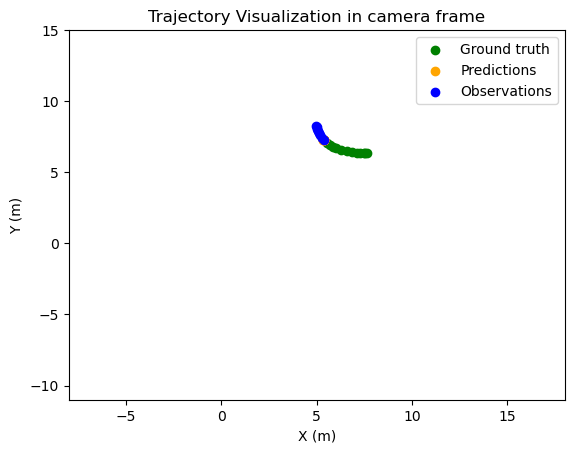

In [15]:
# Running the validation loop to generate prediction trajectories on validation data
validation_loss = []
val_mad = []
val_fad = []

with torch.no_grad():
    # EVALUATION MODE
    model_loaded.eval()

    # validation variables
    batch_val_loss = 0
    gt = []
    pr = []
    obs = []

    for id_b, data in enumerate(val_loader):
        # storing groung truth
        gt.append(data['trg'][:, :, 0:2])
        obs.append(data['src'][:, :, 0:2])
        # input to encoder input
        val_input = (data['src'][:, 1:, 2:4].to(
            device)-mean.to(device))/std.to(device)

        # input to decoder
        start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(
            1).repeat(val_input.shape[0], 1, 1).to(device)
        dec_inp = start_of_seq
        # decoder masks
        dec_source_mask = torch.ones(
            (val_input.shape[0], 1, val_input.shape[1])).to(device)
        dec_target_mask = utils.subsequent_mask(
            dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

        # prediction till horizon lenght
        for i in range(horizon):
            # getting model prediction
            # model_output = model_loaded.forward(
            #     val_input, dec_inp, dec_source_mask, dec_target_mask)

            model_output = model_loaded.forward(val_input, dec_inp)

            # appending the predicition to decoder input for next cycle
            dec_inp = torch.cat((dec_inp, model_output[:, -1:, :]), 1)

        # calculating loss using pairwise distance of all predictions
        val_loss = F.pairwise_distance(dec_inp[:, 1:, 0:2].contiguous().view(-1, 2),
                                        ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).
                                        contiguous().view(-1, 2).to(device)).mean() + \
            torch.mean(torch.abs(dec_inp[:, 1:, 2]))
        batch_val_loss += val_loss.item()

        # calculating the position for each time step of prediction based on velocity
        preds_tr_b = (dec_inp[:, 1:, 0:2]*std.to(device) + mean.to(device)).cpu().numpy().cumsum(1) + \
            data['src'][:, -1:, 0:2].cpu().numpy()

        pr.append(preds_tr_b)
        validation_loss.append(batch_val_loss/len(val_loader))

    # calculating mad and fad evaluation metrics
    gt = np.concatenate(gt, 0)
    pr = np.concatenate(pr, 0)
    obs = np.concatenate(obs, 0)
    mad, fad, _ = dataloader.distance_metrics(gt, pr)
    val_mad.append(mad)
    val_fad.append(fad)

# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

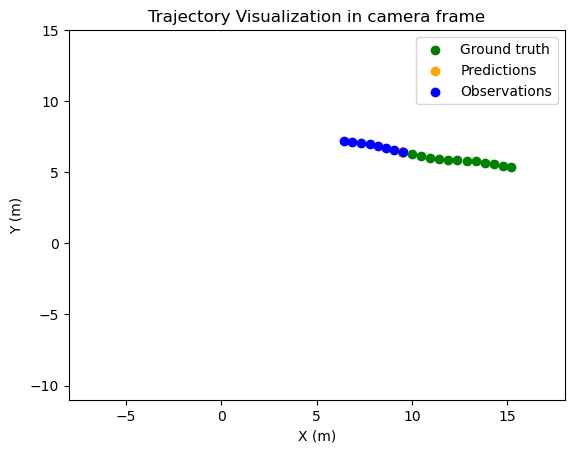

In [29]:
# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

In [25]:
gt[idx, :, 0]

array([4.0474544, 4.4393406, 4.831227 , 5.221429 , 5.610579 , 5.9995184,
       6.3958244, 6.809388 , 7.2227416, 7.645987 , 8.078914 , 8.511841 ],
      dtype=float32)

In [27]:
pr[idx, :, 0]

array([7.8649516, 7.8614554, 7.8579593, 7.854463 , 7.8509674, 7.847471 ,
       7.843975 , 7.840479 , 7.836983 , 7.833487 , 7.829991 , 7.8264947],
      dtype=float32)

In [28]:
pr[idx, :, 1]

array([10.192247, 10.193721, 10.195195, 10.196669, 10.198143, 10.199616,
       10.201091, 10.202564, 10.204039, 10.205512, 10.206986, 10.20846 ],
      dtype=float32)

## 6. Evaluation on test set